## Description
Attached you find a randomly sampled extract of some of our policies.
We want to be able to predict the "number_of_payment_faults" 
(this is the number of payment attempts which failed when we try to charge the money for the policy from the customer) in the future for each new policy.
There is a small legend in the document to describe some of the fields.
If there are open questions about the data you can't answer by yourself do not hesitate to approach us!
Feel free to use whatever tool or language you feel comfortable with to solve the task.

## Task
Create a statistical model to predict the "number_of_payment_faults" for a policy.
There is no fixed or expected outcome what we want to see from you. 
We prefer quality over speed. 
It does not only matter if your solution yields correct results, but also your overall project structure, tools used, etc.


In [174]:
import collections

import math

from datetime import datetime

import statsmodels.formula.api as smf

import pandas as pd
from pandas.api.types import is_string_dtype, is_numeric_dtype

import numpy as np
from numpy import inf

from scipy import stats
from scipy.stats import skew, norm
from scipy.stats import randint as sp_randint

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import pyplot
%matplotlib inline
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')


from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import KFold, cross_val_score, StratifiedKFold, train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor
from sklearn import linear_model
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, BayesianRidge, LassoLarsIC
from sklearn.preprocessing import Normalizer, StandardScaler, RobustScaler
from sklearn import metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, confusion_matrix, classification_report
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone

import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance

import lightgbm as lgb

from hyperopt import hp, tpe, STATUS_OK, Trials
from hyperopt.fmin import fmin

import warnings
warnings.filterwarnings("ignore")
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)

pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points

#from subprocess import check_output
#print(check_output(["ls", "../input"]).decode("utf8")) #check the files available in the directory

np.random.seed(42)

## 1. Load Data

In [316]:
df_friday = pd.read_excel('Your_Dataset.xlsx')

In [317]:
df_friday.shape

(27950, 18)

In [318]:
df_friday.head()

,contract_nr,sf_class_tpl,sf_class_fc,age_insured_person,policy_start,tariff_type,type_of_insurance,comprehensive_product,fc_deductible,pc_deductible,payment_interval,insured_parties,profession_group,car_age_at_purchase,car_age_contract_start,annual_mileage,risk_predictor_zip_code,number_of_payment_faults
0,1,SF1/2,SF1/2,34,YOB,Original,New Vehicle,NaN,0,0,Monthly,Insured and Spouse/Partner,Standard,10,11,12000,5.000,1.000
1,2,SF31,SF31,55,YOB,Original,Change of Insurer,NaN,0,0,Pay In Full,Insured and Spouse/Partner,Standard,2,7,9000,6.000,nan
2,3,SF5,SF5,52,YOB,Original,New Vehicle,VK,300,150,Monthly,Insured and Spouse/Partner,Standard,11,12,20000,1.000,nan
3,4,SF15,SF15,41,YEB,Original,Change of Insurer,TK,0,150,Monthly,Insured and Spouse/Partner,Standard,0,9,15000,6.000,nan
4,5,SF17,SF18,42,YOB,Original,Change of Insurer,VK,300,150,Monthly,Insured and Spouse/Partner,Standard,0,2,15000,3.000,nan


In [319]:
df_train = df_friday[df_friday['number_of_payment_faults'].notnull()]

In [244]:
df_test = df_friday[df_friday['number_of_payment_faults'].isnull()]

In [245]:
df_train.shape

(4789, 18)

In [246]:
df_test.shape

(23161, 18)

In [247]:
df_train.head()

,contract_nr,sf_class_tpl,sf_class_fc,age_insured_person,policy_start,tariff_type,type_of_insurance,comprehensive_product,fc_deductible,pc_deductible,payment_interval,insured_parties,profession_group,car_age_at_purchase,car_age_contract_start,annual_mileage,risk_predictor_zip_code,number_of_payment_faults
0,1,SF1/2,SF1/2,34,YOB,Original,New Vehicle,NaN,0,0,Monthly,Insured and Spouse/Partner,Standard,10,11,12000,5.000,1.000
33,34,SF5,SF5,47,YOB,Original,New Vehicle,TK,0,150,Monthly,Insured and Spouse/Partner,Standard,8,9,9000,8.000,1.000
35,36,SF1/2,SF1/2,37,YOB,Original,First Vehicle,NaN,0,0,Monthly,Insured and Spouse/Partner,Standard,15,16,6000,5.000,2.000
38,39,SF1/2,SF1/2,42,YOB,Original,Change of Insurer,TK,0,150,Monthly,Insured and Spouse/Partner,Standard,1,2,15000,1.000,2.000
47,48,SF23,SF3,63,YEB,Pay per km,Change of Insurer,VK,300,150,Monthly,Insured and Spouse/Partner,Standard,4,5,12000,5.000,1.000


In [248]:
df_test.head()

,contract_nr,sf_class_tpl,sf_class_fc,age_insured_person,policy_start,tariff_type,type_of_insurance,comprehensive_product,fc_deductible,pc_deductible,payment_interval,insured_parties,profession_group,car_age_at_purchase,car_age_contract_start,annual_mileage,risk_predictor_zip_code,number_of_payment_faults
1,2,SF31,SF31,55,YOB,Original,Change of Insurer,NaN,0,0,Pay In Full,Insured and Spouse/Partner,Standard,2,7,9000,6.000,nan
2,3,SF5,SF5,52,YOB,Original,New Vehicle,VK,300,150,Monthly,Insured and Spouse/Partner,Standard,11,12,20000,1.000,nan
3,4,SF15,SF15,41,YEB,Original,Change of Insurer,TK,0,150,Monthly,Insured and Spouse/Partner,Standard,0,9,15000,6.000,nan
4,5,SF17,SF18,42,YOB,Original,Change of Insurer,VK,300,150,Monthly,Insured and Spouse/Partner,Standard,0,2,15000,3.000,nan
5,6,SF7,SF13,37,YOB,Original,New Vehicle,VK,300,150,Monthly,Insured and Spouse/Partner,Standard,0,0,15000,7.000,nan


## 2. EDA and Data Processing

In [249]:
df_friday.head()

,contract_nr,sf_class_tpl,sf_class_fc,age_insured_person,policy_start,tariff_type,type_of_insurance,comprehensive_product,fc_deductible,pc_deductible,payment_interval,insured_parties,profession_group,car_age_at_purchase,car_age_contract_start,annual_mileage,risk_predictor_zip_code,number_of_payment_faults
0,1,SF1/2,SF1/2,34,YOB,Original,New Vehicle,NaN,0,0,Monthly,Insured and Spouse/Partner,Standard,10,11,12000,5.000,1.000
1,2,SF31,SF31,55,YOB,Original,Change of Insurer,NaN,0,0,Pay In Full,Insured and Spouse/Partner,Standard,2,7,9000,6.000,nan
2,3,SF5,SF5,52,YOB,Original,New Vehicle,VK,300,150,Monthly,Insured and Spouse/Partner,Standard,11,12,20000,1.000,nan
3,4,SF15,SF15,41,YEB,Original,Change of Insurer,TK,0,150,Monthly,Insured and Spouse/Partner,Standard,0,9,15000,6.000,nan
4,5,SF17,SF18,42,YOB,Original,Change of Insurer,VK,300,150,Monthly,Insured and Spouse/Partner,Standard,0,2,15000,3.000,nan


In [250]:
df_friday.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27950 entries, 0 to 27949
Data columns (total 18 columns):
contract_nr                 27950 non-null int64
sf_class_tpl                27950 non-null object
sf_class_fc                 27950 non-null object
age_insured_person          27950 non-null int64
policy_start                27940 non-null object
tariff_type                 27950 non-null object
type_of_insurance           27950 non-null object
comprehensive_product       20355 non-null object
fc_deductible               27950 non-null int64
pc_deductible               27950 non-null int64
payment_interval            27950 non-null object
insured_parties             27950 non-null object
profession_group            27950 non-null object
car_age_at_purchase         27950 non-null int64
car_age_contract_start      27950 non-null int64
annual_mileage              27950 non-null int64
risk_predictor_zip_code     27948 non-null float64
number_of_payment_faults    4789 non-null float

In [251]:
df_friday.shape

(27950, 18)

- ### Missing Data

#### Check percentage of missing data

If more than 50% of the data is missing, we should delete the corresponding variable and pretend it never existed. 

In [252]:
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
# missing_data.head(20)
missing_data

,Total,Percent
comprehensive_product,2352,0.965
policy_start,3,0.001
risk_predictor_zip_code,1,0.000
number_of_payment_faults,0,0.000
sf_class_tpl,0,0.000
sf_class_fc,0,0.000
age_insured_person,0,0.000
tariff_type,0,0.000
type_of_insurance,0,0.000
fc_deductible,0,0.000


Text(0.5, 1.0, 'Percent missing data by feature')

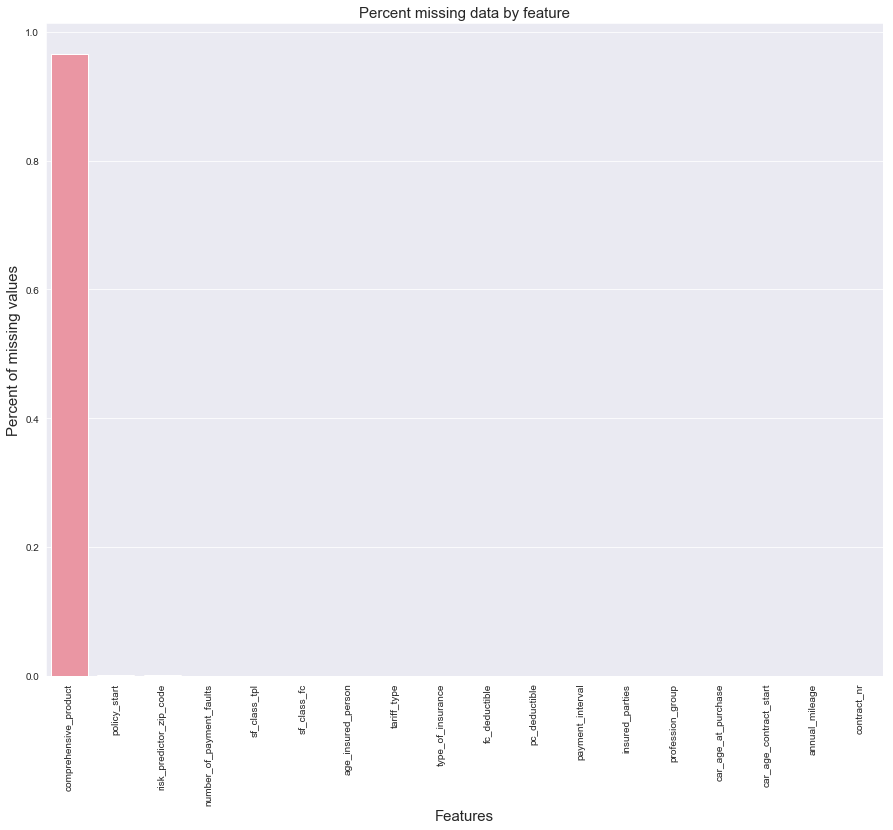

In [253]:
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=percent.index, y=percent)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

In [255]:
df_train.drop('comprehensive_product', axis=1, inplace=True)
df_test.drop('comprehensive_product', axis=1, inplace=True)

In [256]:
# handle the missing values: 
# - create a col_NA column to indicate which row has NAs.
def add_col_na(df_train, target):
    for col in df_train.columns:
        if col != target and is_numeric_dtype(df_train[col]):
            col_vals = df_train[col]
            if sum(col_vals.isnull()) != 0:
                df_train[col+'_na'] = col_vals.isnull()
                df_test[col+'_na'] = df_test[col].isnull()                
    return df_train, df_test

df_train, df_test = add_col_na(df_friday, 'number_of_payment_faults')

In [257]:
df_train.head()

,contract_nr,sf_class_tpl,sf_class_fc,age_insured_person,policy_start,tariff_type,type_of_insurance,comprehensive_product,fc_deductible,pc_deductible,payment_interval,insured_parties,profession_group,car_age_at_purchase,car_age_contract_start,annual_mileage,risk_predictor_zip_code,number_of_payment_faults,risk_predictor_zip_code_na
0,1,SF1/2,SF1/2,34,YOB,Original,New Vehicle,NaN,0,0,Monthly,Insured and Spouse/Partner,Standard,10,11,12000,5.000,1.000,False
1,2,SF31,SF31,55,YOB,Original,Change of Insurer,NaN,0,0,Pay In Full,Insured and Spouse/Partner,Standard,2,7,9000,6.000,nan,False
2,3,SF5,SF5,52,YOB,Original,New Vehicle,VK,300,150,Monthly,Insured and Spouse/Partner,Standard,11,12,20000,1.000,nan,False
3,4,SF15,SF15,41,YEB,Original,Change of Insurer,TK,0,150,Monthly,Insured and Spouse/Partner,Standard,0,9,15000,6.000,nan,False
4,5,SF17,SF18,42,YOB,Original,Change of Insurer,VK,300,150,Monthly,Insured and Spouse/Partner,Standard,0,2,15000,3.000,nan,False


### 'sf_class_tpl' 

In [258]:
df_train['sf_class_tpl'].describe()

count     27950
unique       48
top       SF1/2
freq       3564
Name: sf_class_tpl, dtype: object

In [259]:
df_train['sf_class_tpl'].unique()

array(['SF1/2', 'SF31', 'SF5', 'SF15', 'SF17', 'SF7', 'SF9', 'SF3',
       'SF19', 'SF4', 'SF11', 'SF27', 'SF14', 'SF36', 'SF21', 'SF6',
       'SF18', 'SF2', 'SF22', 'SF16', 'SF29', 'SF25', 'SF33', 'SF23',
       'SF26', 'SF12', 'SF8', 'SF10', 'SF35', 'SF24', 'SF1', 'SF13', 0,
       'SF34', 'SF20', 'SF30', 'SF39', 'SF32', 'SF28', 'SF37', 'M',
       'SF40', 'SF44', 'SF38', 'SF41', 'SF43', 'SF42', 'S'], dtype=object)

In [260]:
len(df_train['sf_class_tpl'].unique())

48

In [261]:
df_train[df_train['sf_class_tpl'].isnull()].shape

(0, 19)

### 'sf_class_fc'

In [262]:
df_train['sf_class_fc'].describe()

count     27950
unique       48
top       SF1/2
freq       3677
Name: sf_class_fc, dtype: object

In [263]:
df_train['sf_class_fc'].unique()

array(['SF1/2', 'SF31', 'SF5', 'SF15', 'SF18', 'SF13', 'SF9', 'SF3',
       'SF14', 'SF4', 'SF11', 'SF27', 'SF20', 'SF36', 'SF30', 'SF16',
       'SF7', 'SF22', 'SF29', 'SF25', 'SF2', 'SF33', 'SF23', 'SF26',
       'SF12', 'SF19', 'SF8', 'SF10', 'SF35', 'SF6', 'SF24', 'SF1',
       'SF21', 0, 'SF34', 'SF17', 'SF39', 'SF32', 'SF28', 'SF37', 'M',
       'SF44', 'SF38', 'SF43', 'SF41', 'SF42', 'SF40', 'S'], dtype=object)

In [264]:
len(df_train['sf_class_fc'].unique())

48

In [265]:
df_train[df_train['sf_class_fc'].isnull()].shape

(0, 19)

### 'policy_start'

In [266]:
df_train['policy_start'].describe()

count     27940
unique        2
top         YOB
freq      16114
Name: policy_start, dtype: object

In [267]:
df_train['policy_start'].unique()

array(['YOB', 'YEB', nan], dtype=object)

In [268]:
df_train[df_train['policy_start'].isnull()].shape

(10, 19)

### 'tariff_type'

In [269]:
df_train['tariff_type'].describe()

count        27950
unique           2
top       Original
freq         24009
Name: tariff_type, dtype: object

In [270]:
df_train['tariff_type'].unique()

array(['Original', 'Pay per km'], dtype=object)

In [271]:
df_train[df_train['tariff_type'].isnull()].shape

(0, 19)

### 'type_of_insurance'

In [272]:
df_train['type_of_insurance'].describe()

count                 27950
unique                    3
top       Change of Insurer
freq                  19349
Name: type_of_insurance, dtype: object

In [273]:
df_train['type_of_insurance'].unique()

array(['New Vehicle', 'Change of Insurer', 'First Vehicle'], dtype=object)

In [274]:
df_train[df_train['type_of_insurance'].isnull()].shape

(0, 19)

### 'payment_interval'

In [275]:
df_train['payment_interval'].describe()

count       27950
unique          2
top       Monthly
freq        27032
Name: payment_interval, dtype: object

In [276]:
df_train['payment_interval'].unique()

array(['Monthly', 'Pay In Full'], dtype=object)

In [277]:
df_train[df_train['payment_interval'].isnull()].shape

(0, 19)

### 'insured_parties'

In [278]:
df_train['insured_parties'].describe()

count                          27950
unique                             2
top       Insured and Spouse/Partner
freq                           24116
Name: insured_parties, dtype: object

In [279]:
df_train['insured_parties'].unique()

array(['Insured and Spouse/Partner', 'Insured and Others'], dtype=object)

In [280]:
df_train[df_train['insured_parties'].isnull()].shape

(0, 19)

### 'profession_group'

In [282]:
df_train['profession_group'].describe()

count        27950
unique           2
top       Standard
freq         23477
Name: profession_group, dtype: object

In [283]:
df_train['profession_group'].unique()

array(['Standard', 'Public service'], dtype=object)

In [284]:
df_train[df_train['profession_group'].isnull()].shape

(0, 19)

### 'age_insured_person'

In [285]:
def report_numerical_variables(df_friday, var_name):
    print('-------------')
    print(var_name)
    print('\n')
    
    print(df_friday[var_name].describe())
    
    sns.distplot(df_friday[var_name])
    
    #skewness and kurtosis
    print("Skewness: %f" % df_friday[var_name].skew())

    df_friday[[var_name]].boxplot()
    pyplot.show()

    df_friday[[var_name]].hist()
    pyplot.show()

    print('mean: {} median: {}'.format(df_friday[var_name].mean(), df_friday[var_name].median()))

    df_friday[df_friday[var_name].isnull()].shape

    sns.distplot(df_friday[var_name], fit=norm)
    fig = plt.figure()

    # https://matplotlib.org/mpl-probscale/tutorial/closer_look_at_viz.html
    res = stats.probplot(df_friday[var_name], plot=plt)
    
    num_null = df_friday[df_friday[var_name].isnull()].shape[0]
    print('number of null rows: {}'.format(num_null))


-------------
age_insured_person


count   27950.000
mean       45.835
std        13.811
min        18.000
25%        35.000
50%        44.000
75%        56.000
max        93.000
Name: age_insured_person, dtype: float64
Skewness: 0.479795


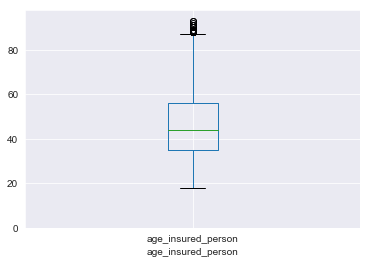

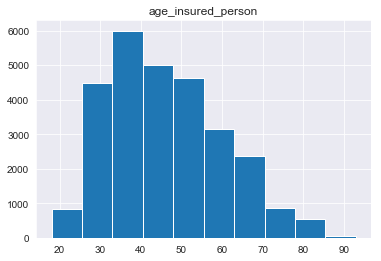

mean: 45.83545617173524 median: 44.0
number of null rows: 0


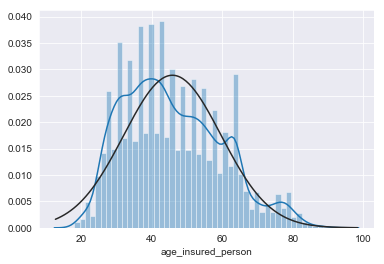

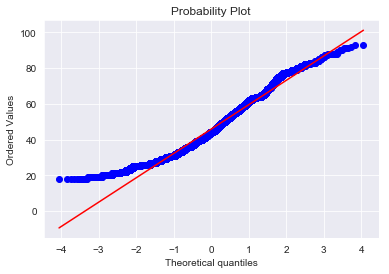

In [286]:
report_numerical_variables(df_train, 'age_insured_person')

### 'fc_deductible'

-------------
fc_deductible


count   27950.000
mean      197.657
std       235.973
min         0.000
25%         0.000
50%       300.000
75%       300.000
max      1000.000
Name: fc_deductible, dtype: float64
Skewness: 1.366917


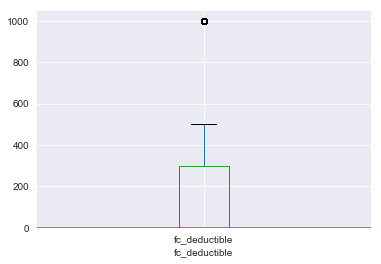

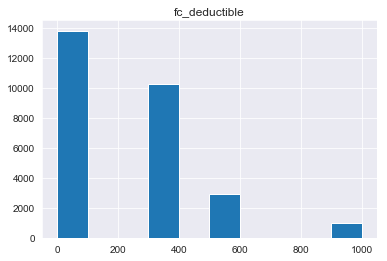

mean: 197.65652951699462 median: 300.0
number of null rows: 0


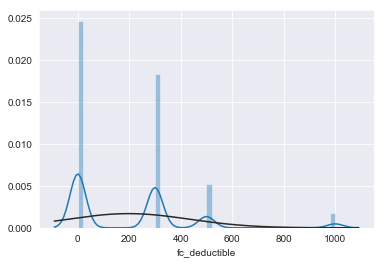

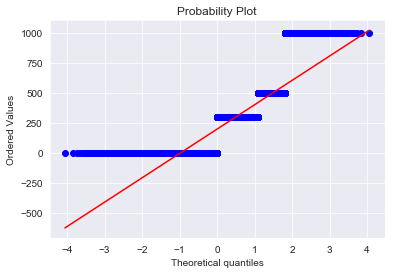

In [287]:
report_numerical_variables(df_train, 'fc_deductible')

### 'pc_deductible'

-------------
pc_deductible


count   27950.000
mean      123.315
std        90.566
min         0.000
25%         0.000
50%       150.000
75%       150.000
max       500.000
Name: pc_deductible, dtype: float64
Skewness: 0.564864


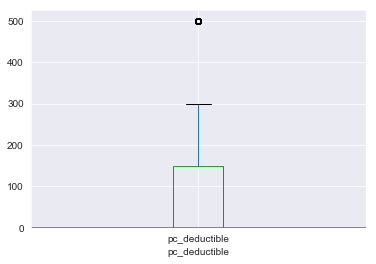

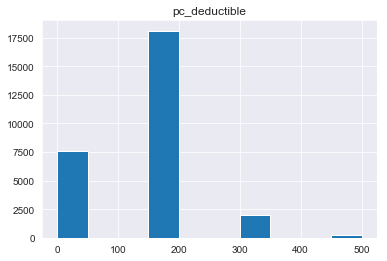

mean: 123.31484794275492 median: 150.0
number of null rows: 0


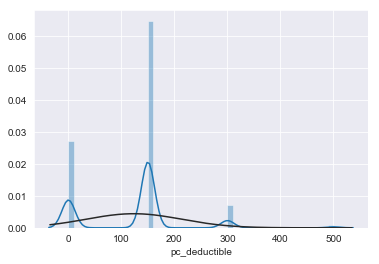

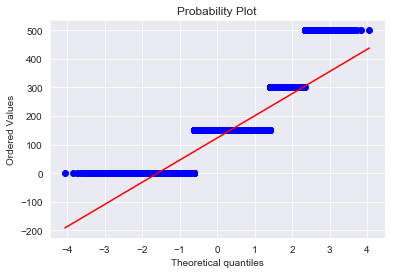

In [288]:
report_numerical_variables(df_train, 'pc_deductible')

### 'car_age_at_purchase'

-------------
car_age_at_purchase


count   27950.000
mean        5.236
std         5.995
min         0.000
25%         0.000
50%         3.000
75%         9.000
max        36.000
Name: car_age_at_purchase, dtype: float64
Skewness: 1.078372


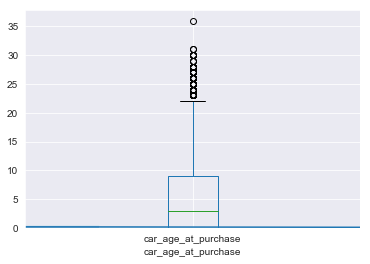

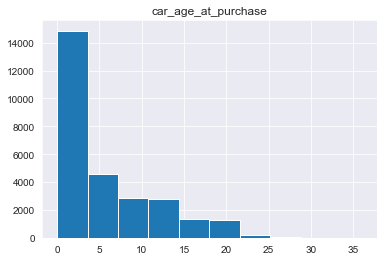

mean: 5.23649373881932 median: 3.0
number of null rows: 0


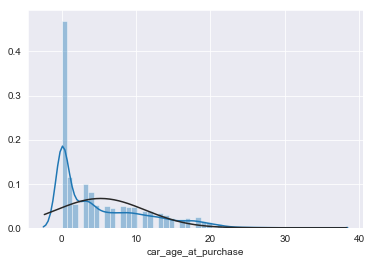

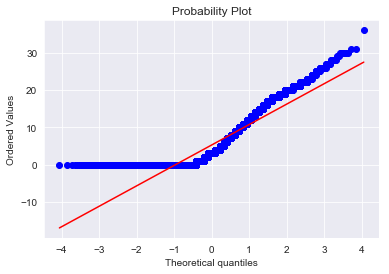

In [289]:
report_numerical_variables(df_train, 'car_age_at_purchase')

### 'car_age_contract_start'

-------------
car_age_contract_start


count   27950.000
mean        8.263
std         6.025
min        -1.000
25%         3.000
50%         8.000
75%        13.000
max        37.000
Name: car_age_contract_start, dtype: float64
Skewness: 0.508749


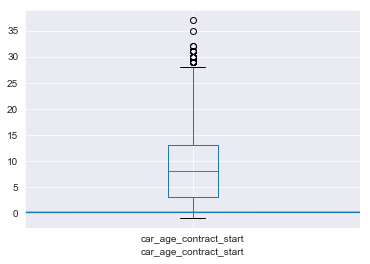

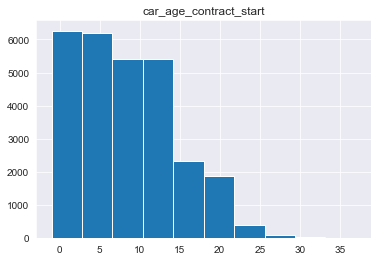

mean: 8.262504472271914 median: 8.0
number of null rows: 0


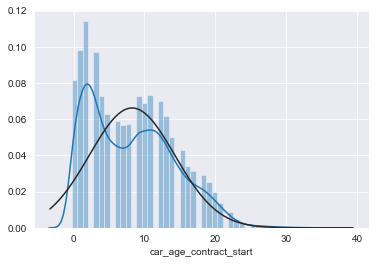

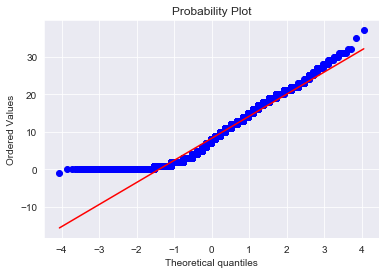

In [290]:
report_numerical_variables(df_train, 'car_age_contract_start')

### 'annual_mileage'

-------------
annual_mileage


count   27950.000
mean    12499.113
std      5744.108
min       600.000
25%      9000.000
50%     12000.000
75%     15000.000
max     90000.000
Name: annual_mileage, dtype: float64
Skewness: 1.335650


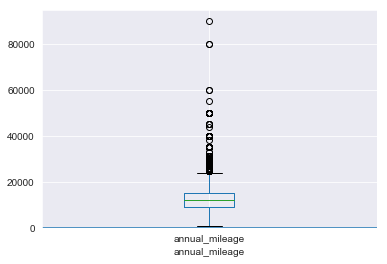

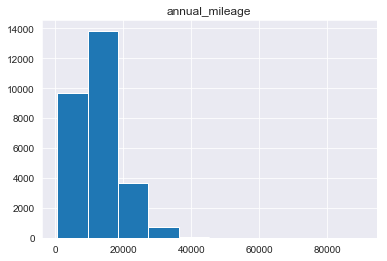

mean: 12499.112701252236 median: 12000.0
number of null rows: 0


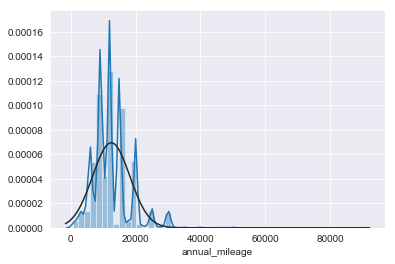

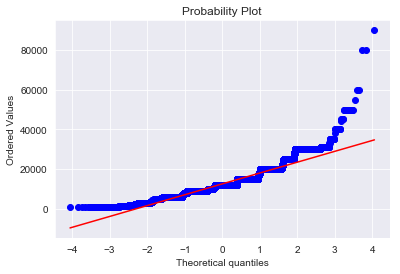

In [291]:
report_numerical_variables(df_train, 'annual_mileage')

### 'risk_predictor_zip_code'

In [292]:
median_risk_pred_zip_code = df_train['risk_predictor_zip_code'].median()
median_risk_pred_zip_code

5.0

In [293]:
df_train['risk_predictor_zip_code'].fillna(median_risk_pred_zip_code, inplace=True)
df_test['risk_predictor_zip_code'].fillna(median_risk_pred_zip_code, inplace=True)

In [294]:
df_train['risk_predictor_zip_code'] = df_train['risk_predictor_zip_code'].apply(int)
df_test['risk_predictor_zip_code'] = df_test['risk_predictor_zip_code'].apply(int)

-------------
risk_predictor_zip_code


count   27950.000
mean        5.056
std         2.527
min         1.000
25%         3.000
50%         5.000
75%         7.000
max         9.000
Name: risk_predictor_zip_code, dtype: float64
Skewness: -0.009418


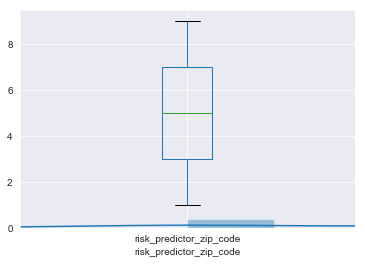

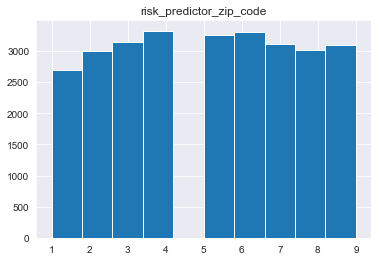

mean: 5.056457960644007 median: 5.0
number of null rows: 0


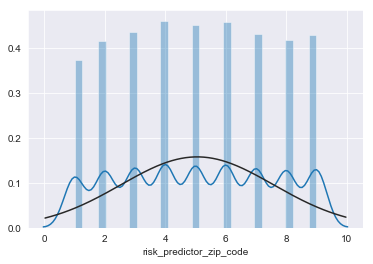

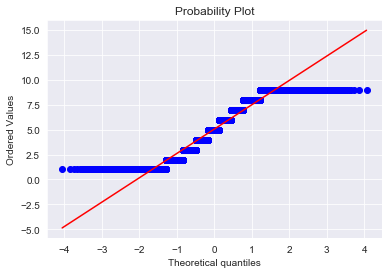

In [295]:
report_numerical_variables(df_train, 'risk_predictor_zip_code')

- ### Skewness


Transform the skewed numeric features by taking log(feature + 1). This will make the features more normal.

https://www.kaggle.com/humananalog/xgboost-lasso/code

Other approaches:

Box Cox Transformation of (highly) skewed features

https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard

In [296]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27950 entries, 0 to 27949
Data columns (total 19 columns):
contract_nr                   27950 non-null int64
sf_class_tpl                  27950 non-null object
sf_class_fc                   27950 non-null object
age_insured_person            27950 non-null int64
policy_start                  27940 non-null object
tariff_type                   27950 non-null object
type_of_insurance             27950 non-null object
comprehensive_product         20355 non-null object
fc_deductible                 27950 non-null int64
pc_deductible                 27950 non-null int64
payment_interval              27950 non-null object
insured_parties               27950 non-null object
profession_group              27950 non-null object
car_age_at_purchase           27950 non-null int64
car_age_contract_start        27950 non-null int64
annual_mileage                27950 non-null int64
risk_predictor_zip_code       27950 non-null int64
number_of_payme

In [298]:
numeric_features = ['fc_deductible', 'pc_deductible', 'car_age_at_purchase', 
                    'car_age_contract_start', 'annual_mileage', 'risk_predictor_zip_code'] 

In [299]:
skewed = df_train[numeric_features].apply(lambda x: skew(x.dropna().astype(int)))
skewed = skewed[skewed > 0.75]
skewed = skewed.index

df_train[skewed] = np.log1p(df_train[skewed])
df_test[skewed] = np.log1p(df_test[skewed])

- ### Outliers

Some outliers could be removed, however outliers removal is note always safe. 
I decided not to delete any of the outliers, because I found there are many outliers in the dataset.
On the other hand, as indicated by https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard
removing all outliers may affect badly the models if ever there were also outliers in the test data. That's why , instead of removing them all, we will just manage to make some of our models robust on them. 


- ### Scale numerical features

In [300]:
scaler = StandardScaler()
scaler.fit(df_train[numeric_features])

scaled = scaler.transform(df_train[numeric_features])
for i, col in enumerate(numeric_features):
    df_train[col] = scaled[:, i]
    
scaled = scaler.transform(df_test[numeric_features])
for i, col in enumerate(numeric_features):
    df_test[col] = scaled[:, i]


- ### One-hot encode categorical features


In [301]:
def onehot(onehot_df, df, column_name, fill_na=None):
    onehot_df[column_name] = df[column_name]
    if fill_na is not None:
        onehot_df[column_name].fillna(fill_na, inplace=True)
    
    dummies = pd.get_dummies(onehot_df[column_name], prefix="_" + column_name)
    
    onehot_df = onehot_df.join(dummies)
    onehot_df = onehot_df.drop([column_name], axis=1)
    
    return onehot_df

In [302]:
categorical_features = ['sf_class_tpl', 'sf_class_fc', 'policy_start', 
                        'tariff_type', 'type_of_insurance', 'comprehensive_product', 
                        'payment_interval', 'insured_parties', 'profession_group'] 

In [304]:
#http://queirozf.com/entries/one-hot-encoding-a-feature-on-a-pandas-dataframe-an-example
#https://stackoverflow.com/questions/41335718/keep-same-dummy-variable-in-training-and-testing-data
    
dataset = pd.concat(objs=[df_train, df_test], axis=0)

for categorical_feature in categorical_features:
    # use pd.concat to join the new columns with your original dataframe
    dataset = pd.concat([dataset, pd.get_dummies(dataset[categorical_feature], prefix=categorical_feature, dummy_na=True)], axis=1)
    
    # now drop the original 'country' column (you don't need it anymore)
    dataset.drop([categorical_feature], axis=1, inplace=True)

train_len = len(df_train)
df_train = dataset[:train_len]
df_test = dataset[train_len:]

In [305]:
print(df_train.columns)

Index(['age_insured_person', 'annual_mileage', 'car_age_at_purchase',
       'car_age_contract_start', 'contract_nr', 'fc_deductible',
       'number_of_payment_faults', 'pc_deductible', 'risk_predictor_zip_code',
       'risk_predictor_zip_code_na',
       ...
       'comprehensive_product_nan', 'payment_interval_Monthly',
       'payment_interval_Pay In Full', 'payment_interval_nan',
       'insured_parties_Insured and Others',
       'insured_parties_Insured and Spouse/Partner', 'insured_parties_nan',
       'profession_group_Public service', 'profession_group_Standard',
       'profession_group_nan'],
      dtype='object', length=130)


- ### Convert boolean features to integer
We could also convert boolean features with one-hot encoding, if we want to us linear regression, neural networks, svm as regressors.

In [306]:
df_train.head()

,age_insured_person,annual_mileage,car_age_at_purchase,car_age_contract_start,contract_nr,fc_deductible,number_of_payment_faults,pc_deductible,risk_predictor_zip_code,risk_predictor_zip_code_na,...,comprehensive_product_nan,payment_interval_Monthly,payment_interval_Pay In Full,payment_interval_nan,insured_parties_Insured and Others,insured_parties_Insured and Spouse/Partner,insured_parties_nan,profession_group_Public service,profession_group_Standard,profession_group_nan
0,34,0.138,1.011,0.454,1,-1.009,1.000,-1.362,-0.022,False,...,1,1,0,0,0,1,0,0,1,0
1,55,-0.435,-0.176,-0.210,2,-1.009,nan,-1.362,0.373,False,...,1,0,1,0,0,1,0,0,1,0
2,52,1.156,1.090,0.620,3,0.920,nan,0.295,-1.605,False,...,0,1,0,0,0,1,0,0,1,0
3,41,0.582,-1.179,0.122,4,-1.009,nan,0.295,0.373,False,...,0,1,0,0,0,1,0,0,1,0
4,42,0.582,-1.179,-1.039,5,0.920,nan,0.295,-0.814,False,...,0,1,0,0,0,1,0,0,1,0


In [307]:
bool_feature_columns = df_train.dtypes[df_train.dtypes == "bool"].index
bool_feature_columns.values

print(bool_feature_columns)

Index(['risk_predictor_zip_code_na'], dtype='object')


In [308]:
for bool_feature_col in bool_feature_columns:
    df_train[bool_feature_col] = df_train[bool_feature_col].astype('int32')
    df_test[bool_feature_col] = df_test[bool_feature_col].astype('int32')

In [309]:
df_train.head()

,age_insured_person,annual_mileage,car_age_at_purchase,car_age_contract_start,contract_nr,fc_deductible,number_of_payment_faults,pc_deductible,risk_predictor_zip_code,risk_predictor_zip_code_na,...,comprehensive_product_nan,payment_interval_Monthly,payment_interval_Pay In Full,payment_interval_nan,insured_parties_Insured and Others,insured_parties_Insured and Spouse/Partner,insured_parties_nan,profession_group_Public service,profession_group_Standard,profession_group_nan
0,34,0.138,1.011,0.454,1,-1.009,1.000,-1.362,-0.022,0,...,1,1,0,0,0,1,0,0,1,0
1,55,-0.435,-0.176,-0.210,2,-1.009,nan,-1.362,0.373,0,...,1,0,1,0,0,1,0,0,1,0
2,52,1.156,1.090,0.620,3,0.920,nan,0.295,-1.605,0,...,0,1,0,0,0,1,0,0,1,0
3,41,0.582,-1.179,0.122,4,-1.009,nan,0.295,0.373,0,...,0,1,0,0,0,1,0,0,1,0
4,42,0.582,-1.179,-1.039,5,0.920,nan,0.295,-0.814,0,...,0,1,0,0,0,1,0,0,1,0


- ### Log-transformation of the target variable

As (linear) models work well on normally distributed data, we need to transform the variable and make it more normally distributed.

In [314]:
# https://www.kaggle.com/humananalog/xgboost-lasso/code
# https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard

df_train['number_of_payment_faults'] = df_train['number_of_payment_faults'].astype('int32')

df_target = pd.DataFrame(index = df_train.index, columns=['number_of_payment_faults'])
df_target['number_of_payment_faults'] = np.log1p(df_train['number_of_payment_faults'])

ValueError: Cannot convert non-finite values (NA or inf) to integer